Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

# Permuation 


In [1]:
import pandas as pd
df = pd.read_csv('yelp30kuser.csv')


In [2]:
# remind ourselves what we are trying to predict 
y = df['review_count']
import seaborn as sns 
sns.distplot(y);

In [3]:
def engineer(X):
    """A function to engineer the training, validation and test datasets in the same way"""
    # Making a copy as not to modify the original dataset 
    X = X.copy()
    
    # Format this column into a datetime type to extract year, month, and day 
    X['yelping_since'] = pd.to_datetime(X['yelping_since'])
    X['user_created_year'] = X['yelping_since'].dt.year
    X['user_created_month'] = X['yelping_since'].dt.month
    X['user_created_day']= X['yelping_since'].dt.day 
    X = X.drop(columns='yelping_since') # drop original 
    
    
    # these columns were found through permutation importances for random forest
    remove = ['fans', 'elite', 'compliment_writer',
              'name', 'compliment_photos', 'user_created_year']
    
    
    X = X.drop(columns=remove)
    # Convert this column from a float into an integer value
    # Since floats cannot be used as targets in a model 
#     X["target_star"] = X['average_stars'].astype(int)
    
    # X['review_count_bin'] = pd.qcut(X['review_count'], q=10, duplicates='drop')
    
    # There's no spaces in the column names but this code might be useful anyway                                
    X.columns = [col.replace(' ', '_') for col in X]
    
    return X

In [4]:
# Engineer the data to work with plots 
import plotly.express as px
df_engineered = engineer(df)
df_engineered.dtypes

Unnamed:_0              int64
user_id                object
review_count            int64
useful                  int64
funny                   int64
cool                    int64
friends                object
average_stars         float64
compliment_hot          int64
compliment_more         int64
compliment_profile      int64
compliment_cute         int64
compliment_list         int64
compliment_note         int64
compliment_plain        int64
compliment_cool         int64
compliment_funny        int64
user_created_month      int64
user_created_day        int64
dtype: object

In [5]:
# Split the dataframe into training and validation sets 
from sklearn.model_selection import train_test_split
training, validation = train_test_split(df, test_size =0.1, shuffle=True, random_state=42)
training.shape, validation.shape

((27000, 23), (3000, 23))

In [6]:

# Engineer and separate X and y 
train = engineer(training)
val = engineer(validation)

target = "review_count"

X_train = train.drop(columns=target)
y_train = train[target]

X_val = val.drop(columns=target)
y_val = val[target]

In [ ]:
column  = 'average_stars'

# Fit without column
pipeline = make_pipeline(
     ce.OrdinalEncoder(), 
     SimpleImputer(strategy='median'), 
    LinearRegression()
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline = make_pipeline(
     ce.OrdinalEncoder(), 
     SimpleImputer(strategy='median'), 
    LinearRegression()
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

In [8]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Random Forest Validation Accuracy', pipeline.score(X_val, y_val))

Random Forest Validation Accuracy 0.25366666666666665


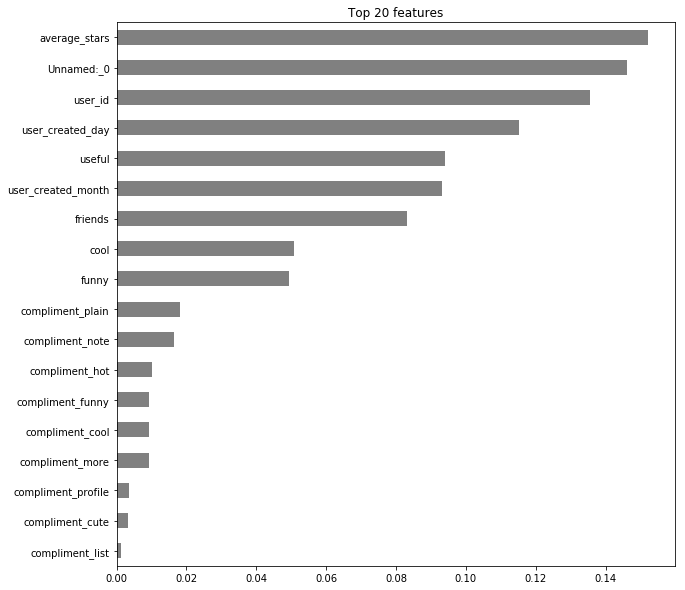

In [9]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [10]:
for column in X_train.columns:
    # Fit without column
    pipeline = make_pipeline(
        ce.OrdinalEncoder(), 
        SimpleImputer(strategy='median'), 
        RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    )
    pipeline.fit(X_train.drop(columns=column), y_train)
    score_without = pipeline.score(X_val.drop(columns=column), y_val)
    print(f'Validation Accuracy without {column}: {score_without}')

    # Fit with column
    pipeline = make_pipeline(
        ce.OrdinalEncoder(), 
        SimpleImputer(strategy='median'), 
        RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    )
    pipeline.fit(X_train, y_train)
    score_with = pipeline.score(X_val, y_val)
    print(f'Validation Accuracy with {column}: {score_with}')

    # Compare the error with & without column
    print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without Unnamed:_0: 0.247
Validation Accuracy with Unnamed:_0: 0.25366666666666665
Drop-Column Importance for Unnamed:_0: 0.006666666666666654
Validation Accuracy without user_id: 0.25033333333333335
Validation Accuracy with user_id: 0.25366666666666665
Drop-Column Importance for user_id: 0.0033333333333332993
Validation Accuracy without useful: 0.24533333333333332
Validation Accuracy with useful: 0.25366666666666665
Drop-Column Importance for useful: 0.008333333333333331
Validation Accuracy without funny: 0.25233333333333335
Validation Accuracy with funny: 0.25366666666666665
Drop-Column Importance for funny: 0.0013333333333332975
Validation Accuracy without cool: 0.25233333333333335
Validation Accuracy with cool: 0.25366666666666665
Drop-Column Importance for cool: 0.0013333333333332975
Validation Accuracy without friends: 0.244
Validation Accuracy with friends: 0.25366666666666665
Drop-Column Importance for friends: 0.009666666666666657
Validation Accuracy withou

In [ ]:
select = ['Unnamed_0', 'name', 'useful',
                           'elite', 'average_stars', 'compliment_cute',
                           'compliment_plain', 'compliment_funny',
                           'compliment_write', 'user_created_month', 'user_created_day']
X_train, X_val = pd.DataFrame(X_train, columns=select), pd.DataFrame(X_val, columns=select)

In [12]:
# Prepare for Permutation importances 
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer

transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)


In [14]:
X_train.shape, X_val.shape

((27000, 18), (3000, 18))

In [15]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(n_jobs=-1)

# No difference
model.fit(X_train_transformed, y_train)

print('Training Accuracy', model.score(X_train_transformed, y_train))
print('Validation Accuracy', model.score(X_val_transformed, y_val))

Training Accuracy 0.7955992778095625
Validation Accuracy 0.7056969881906694


In [16]:
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [17]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [18]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

average_stars         0.102333
useful                0.039533
funny                 0.015400
Unnamed:_0            0.010533
cool                  0.008467
compliment_note       0.003800
user_created_month    0.003667
user_created_day      0.000533
compliment_funny      0.000533
compliment_cute       0.000333
compliment_more       0.000133
friends               0.000000
user_id               0.000000
compliment_list      -0.000067
compliment_plain     -0.000067
compliment_hot       -0.000133
compliment_profile   -0.000333
compliment_cool      -0.000667
dtype: float64

In [19]:
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None, # show permutation importances for all features
    feature_names=feature_names
)

Weight,Feature
0.1023 ± 0.0077,average_stars
0.0395 ± 0.0073,useful
0.0154 ± 0.0028,funny
0.0105 ± 0.0095,Unnamed:_0
0.0085 ± 0.0077,cool
0.0038 ± 0.0023,compliment_note
0.0037 ± 0.0042,user_created_month
0.0005 ± 0.0047,user_created_day
0.0005 ± 0.0014,compliment_funny
0.0003 ± 0.0008,compliment_cute


In [20]:
print('Shape before removing features:', X_train.shape)

Shape before removing features: (27000, 18)


In [21]:
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

In [22]:
X_val = X_val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)

# this is better for decision tree, this indicates that dropping colums that improve the decision
# decision tree/random forest do not improve the accuracy for linear regression 
# which makes sense intuitively I guess 
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.25933333333333336


# The Random Forest score improved with dropping negative importance columns. 
When I tried dropping the same columns from the Linear Regression the score didn't improve, which makes sense intuitively since a straight line isn't going to be effected by small differences like a decision tree will.  

In [23]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=10, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.18966666666666668


# Gradient Boosting is significantly more accurate than Random Forest 

In [24]:
# Split the dataframe into training and validation sets 
import pandas as pd
df = pd.read_csv('yelp30kuser.csv')

def engineer(X):
    """A function to engineer the training, validation and test datasets in the same way"""
    # Making a copy as not to modify the original dataset 
    X = X.copy()
    
    # Format this column into a datetime type to extract year, month, and day 
    X['yelping_since'] = pd.to_datetime(X['yelping_since'])
    X['user_created_year'] = X['yelping_since'].dt.year
    X['user_created_month'] = X['yelping_since'].dt.month
    X['user_created_day']= X['yelping_since'].dt.day 
    X = X.drop(columns='yelping_since') # drop original 
    
    
    # these columns were found through permutation importances for random forest
    remove = ['fans', 'elite', 'compliment_writer',
              'name', 'compliment_photos', 'user_created_year']
    
    
    X = X.drop(columns=remove)
    # Convert this column from a float into an integer value
    # Since floats cannot be used as targets in a model 
#     X["target_star"] = X['average_stars'].astype(int)
    
    # X['review_count_bin'] = pd.qcut(X['review_count'], q=10, duplicates='drop')
    
    # There's no spaces in the column names but this code might be useful anyway                                
    X.columns = [col.replace(' ', '_') for col in X]
    
    return X

from sklearn.model_selection import train_test_split
training, validation = train_test_split(df, test_size =0.1, shuffle=True, random_state=42)
training.shape, validation.shape


((27000, 23), (3000, 23))

In [25]:
# Engineer and separate X and y 
train = engineer(training)
val = engineer(validation)

target = "review_count"

X_train = train.drop(columns=target)
y_train = train[target]

X_val = val.drop(columns=target)
y_val = val[target]




In [27]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor

transformers = make_pipeline(ce.OrdinalEncoder(), SimpleImputer())
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

eval_set = [(X_train_transformed, y_train), 
            (X_val_transformed, y_val)]

model = XGBRegressor(
    n_estimators=1000, 
    max_depth=10, 
    objective='reg:squarederror', 
    n_jobs=-1, 
)


model.fit(X_train_transformed, y_train, eval_set=eval_set, 
          eval_metric='mae', early_stopping_rounds=20)

[0]	validation_0-mae:20.6874	validation_1-mae:17.0264
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 20 rounds.
[1]	validation_0-mae:18.7299	validation_1-mae:15.4738
[2]	validation_0-mae:17.0043	validation_1-mae:14.1356
[3]	validation_0-mae:15.4704	validation_1-mae:12.9366
[4]	validation_0-mae:14.1277	validation_1-mae:11.9276
[5]	validation_0-mae:12.9529	validation_1-mae:11.1271
[6]	validation_0-mae:11.9384	validation_1-mae:10.4571
[7]	validation_0-mae:11.0507	validation_1-mae:9.92041


C:\Users\Ryloid\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\Ryloid\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[8]	validation_0-mae:10.2842	validation_1-mae:9.49228
[9]	validation_0-mae:9.61777	validation_1-mae:9.14603
[10]	validation_0-mae:9.03224	validation_1-mae:8.88705
[11]	validation_0-mae:8.51863	validation_1-mae:8.7215
[12]	validation_0-mae:8.08086	validation_1-mae:8.58835
[13]	validation_0-mae:7.6962	validation_1-mae:8.47369
[14]	validation_0-mae:7.36238	validation_1-mae:8.39192
[15]	validation_0-mae:7.06296	validation_1-mae:8.34288
[16]	validation_0-mae:6.80035	validation_1-mae:8.32127
[17]	validation_0-mae:6.56649	validation_1-mae:8.30391
[18]	validation_0-mae:6.35212	validation_1-mae:8.31133
[19]	validation_0-mae:6.17488	validation_1-mae:8.31493
[20]	validation_0-mae:6.02427	validation_1-mae:8.32975
[21]	validation_0-mae:5.89392	validation_1-mae:8.3935
[22]	validation_0-mae:5.7663	validation_1-mae:8.44855
[23]	validation_0-mae:5.66285	validation_1-mae:8.48996
[24]	validation_0-mae:5.5689	validation_1-mae:8.55971
[25]	validation_0-mae:5.48035	validation_1-mae:8.5995
[26]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)